In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

DATA_PATH = '../cell_data/data/lognorm-evaluation/eval/max/fibronectin_full/'
RESULT_PATH = './results/2nd_run'

In [3]:
result_paths = [ { 'name': name, 'path': os.path.join(RESULT_PATH, name)} 
                for name in os.listdir(RESULT_PATH) if os.path.isdir(os.path.join(RESULT_PATH, name))]
# experiments = {result['path']: [os.path.join(result['path'], name) for name in os.listdir(result['path'])] for result in result_paths}
experiments = [ {'name': result['name'],'path': result['path'], 
                 'experiments': sorted([os.path.join(result['path'], name) 
                                        for name in os.listdir(result['path']) if os.path.isdir(os.path.join(result['path'], name))])} for result in result_paths]
result_paths, experiments

([{'name': 'cnn', 'path': './results/2nd_run/cnn'},
  {'name': 'mlp', 'path': './results/2nd_run/mlp'},
  {'name': 'encoder', 'path': './results/2nd_run/encoder'},
  {'name': 'mcdcnn', 'path': './results/2nd_run/mcdcnn'},
  {'name': 'fcn', 'path': './results/2nd_run/fcn'},
  {'name': 'resnet', 'path': './results/2nd_run/resnet'},
  {'name': 'inception', 'path': './results/2nd_run/inception'}],
 [{'name': 'cnn',
   'path': './results/2nd_run/cnn',
   'experiments': ['./results/2nd_run/cnn/fibronectin_full_itr_0',
    './results/2nd_run/cnn/fibronectin_full_itr_1',
    './results/2nd_run/cnn/fibronectin_full_itr_2',
    './results/2nd_run/cnn/fibronectin_full_itr_3',
    './results/2nd_run/cnn/fibronectin_full_itr_4']},
  {'name': 'mlp',
   'path': './results/2nd_run/mlp',
   'experiments': ['./results/2nd_run/mlp/fibronectin_full_itr_0',
    './results/2nd_run/mlp/fibronectin_full_itr_1',
    './results/2nd_run/mlp/fibronectin_full_itr_2',
    './results/2nd_run/mlp/fibronectin_full_itr

In [ ]:
# obj = experiments[0]
# fig, ax = plt.subplots(2,2, figsize=(15,8))
# for m, experiment in enumerate(obj['experiments']):
#     exp_hist = pd.read_csv(os.path.join(experiment, 'history.csv'))
#     ax[0,0].plot(exp_hist.loss)
#     ax[0,1].plot(exp_hist.val_loss)
#     ax[1,0].plot(exp_hist.accuracy)
#     ax[1,1].plot(exp_hist.val_accuracy)
#     ax[1,0].set_ylim((0,1))
#     ax[1,1].set_ylim((0,1))
# plt.show()

In [6]:
def log(func):
    def wrap(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        
        print('Generated', args[0], round(end-start, 2), 's')
        return result
    return wrap

def get_max_acc_experiment(experiment):
    mx_idx = 0
    max_accs = 0
    for n, exp in enumerate(experiment['experiments']):
        exp_hist = pd.read_csv(os.path.join(exp, 'history.csv'))
        mx = max(exp_hist.val_accuracy)
        if max_accs < mx:
            mx_idx = n
            max_accs = mx
    return mx_idx

def get_predictions(experiment, labels):
    preds = pd.read_csv(os.path.join(experiment, 'true-pred-values.csv'))
    y_pred = np.array(preds.pred)
    pred_labels = [labels[y_pred[n]] for n in range(y_pred.shape[0])]
    return y_pred, pred_labels

def get_test(path, labels):
    x_test = np.load(os.path.join(path, 'X_test.npy'))
    y_test = np.load(os.path.join(path, 'y_test.npy'))
    test_labels = [labels[y_test[n]] for n in range(y_test.shape[0])]
    return x_test, y_test, test_labels

def get_dictionary(path):
    dictionary = pd.read_csv(os.path.join(path, 'dictionary.csv'))
    labels = list(dictionary.iloc[:, 0])
    label_ids = list(dictionary.iloc[:, 1])
    return labels, label_ids

In [7]:
@log
def generate_loss_acc_plot(filename, experiment):
    fig, ax = plt.subplots(2,2, figsize=(15,8))
    plt.suptitle(experiment['name'])
    ax[0,0].set_title("Trn loss")
    ax[0,1].set_title("Val loss")
    ax[1,0].set_title("Trn Accuracy")
    ax[1,1].set_title("Val Accuracy")
    for n, exp in enumerate(experiment['experiments']):
        exp_hist = pd.read_csv(os.path.join(exp, 'history.csv'))
        ax[0,0].plot(exp_hist.loss, label=n)
        ax[0,1].plot(exp_hist.val_loss, label=n)
        ax[1,0].plot(exp_hist.accuracy, label=n)
        ax[1,1].plot(exp_hist.val_accuracy, label=n)
    ax[0,0].legend()
    ax[0,1].legend()
    ax[1,0].legend()
    ax[1,1].legend()
    ax[1,0].set_ylim((0,1))
    ax[1,1].set_ylim((0,1))
    plt.savefig(filename)
    plt.close()
    
@log
def generate_tr_tst_plot(filename, experiments):   
    fig, ax = plt.subplots(1,2, figsize=(15,8))
    ax[0].set_title("Trn Accuracy")
    ax[1].set_title("Val Accuracy")
    for exp in experiments:
    #     if exp['name'] not in ['resnet', 'fcn']: 
        mx_idx = get_max_acc_experiment(exp)
        exp_hist = pd.read_csv(os.path.join(exp['experiments'][mx_idx], 'history.csv'))
        ax[0].plot(exp_hist.accuracy, label=exp['name'], alpha=.5)
        ax[1].plot(exp_hist.val_accuracy, label=exp['name'], alpha=.5)
    ax[0].legend()
    ax[1].legend()
    ax[0].set_xlim((0, 400))
    ax[1].set_xlim((0, 400))
    plt.savefig(filename)
    plt.close()

@log
def generate_tst_pred_plot(experiment, x_test, y_test, labels):
    label_count = len(labels)
    cmap = mpl.cm.get_cmap('Set1', label_count)
    y_pred, _ = get_predictions(experiment, labels)
    fig, ax = plt.subplots(5,1, figsize=(15,50))
    fig.suptitle("Test predictions")
    for i in range(label_count):
        for j in range(label_count):
            ax[i].plot([], c=cmap(j), label=labels[j])
        ax[i].legend()
        ax[i].set_title(''.join([labels[i], '-predictions']))

    for n in range(x_test.shape[0]):
        ax[y_test[n]].plot(x_test[n,:], c=cmap(y_pred[n]))
    plt.savefig(os.path.join(experiment, 'tst-predictions-types.png'))
    plt.close()

@log
def generate_preds_plot(experiment, x_test, y_test, labels):
    label_count = len(labels)
    cmap = ['r', 'g']
    y_pred, _ = get_predictions(experiment, labels)
    fig, ax = plt.subplots(5,1, figsize=(15,50))
    for i in range(label_count):
        for n, label in enumerate(['false', 'true']):
            ax[i].plot([], c=cmap[n], label=label)
        ax[i].legend()
        ax[i].set_title(''.join([labels[i], '_predictions']))
            
    for m in range(x_test.shape[0]):
        ax[y_test[n]].plot(x_test[m, :], c=cmap[int(y_pred[m] == y_test[m])])
    plt.savefig(os.path.join(experiment, 'tst-predictions.png'))
    plt.close()

@log
def generate_test_hist_plot(filename, x_test, y_test, labels, label_ids):
    label_count = len(labels)
    x_test_lst = x_test[:, -1]
    separated_x_test = [ x_test[np.where(y_test == n)] for n in label_ids]
    bins_type = []
    for x_test_type in separated_x_test:
        bins, bin_edges = np.histogram(x_test_type[:, -1], bins=50, range=(min(x_test_lst), max(x_test_lst)),density=False)
        bins_type.append(bins)
    bins, bin_edges = np.histogram(x_test_lst, bins=50, range=(min(x_test_lst), max(x_test_lst)),density=False)
    cmap = mpl.cm.get_cmap('Set1', label_count)
    plt.figure(figsize=(12,8))
    for m in label_ids:
        plt.bar(0, 0, width=0, color=cmap(m), label=labels[m])
    for n, (l_edge, r_edge) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
        bottom = 0
        for m in label_ids:
            plt.bar(l_edge, bins_type[m][n], width=(r_edge - l_edge), color=cmap(m), edgecolor='black', linewidth=.2, bottom=bottom)
            bottom += bins_type[m][n]
    plt.legend()
    plt.savefig(filename)
    plt.close()

@log
def generate_test_type_hist_plot(experiment, x_test, y_test, labels, label_ids):
    label_count = len(labels)
    x_test_lst = x_test[:, -1]
    cmap = mpl.cm.get_cmap('Set1', label_count)
    y_pred, _ = get_predictions(experiment, labels)
    fig, ax = plt.subplots(label_count, 1, figsize=(12, label_count * 8))
    fig.suptitle("Test predictions histogram")
    for i, (name, tag) in enumerate(zip(labels, label_ids)):
        label_ids_l = label_ids[i:] + label_ids[:i]
        label_slice = np.where(y_test == tag)
        x_test_type = x_test[label_slice]
        x_test_type_lst = x_test_type[:, -1]
        # y_test_type = y_test[label_slice]
        y_pred_type = y_pred[label_slice]
        bins_type = []
        for n in label_ids:
            bins, bin_edges = np.histogram(x_test_type_lst[np.where(y_pred_type == n)], bins=50, range=(min(x_test_lst), max(x_test_lst)),density=False)
            bins_type.append(bins)
        bins, bin_edges = np.histogram(x_test_type_lst, bins=50, range=(min(x_test_lst), max(x_test_lst)),density=False)
        ax[tag].set_title(' '.join([name, 'predictions']))
        for m in label_ids:
            container = ax[tag].bar(0, 0, width=0, color=cmap(m), label=labels[m])
        for n, (l_edge, r_edge) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
            bottom = 0
            for m in label_ids_l:
                container = ax[tag].bar(l_edge, bins_type[m][n], width=(r_edge - l_edge), color=cmap(m), edgecolor='black', linewidth=.2, bottom=bottom)
                bottom += bins_type[m][n]
        ax[tag].legend()
    plt.savefig(os.path.join(experiment, 'tst-types-hist.png'))
    plt.close()

In [ ]:
labels, label_ids = get_dictionary(DATA_PATH)
x_test, y_test, test_labels = get_test(DATA_PATH, labels)
# successfull_pred = y_test == y_pred

print("Generating loss-accuracy plots")
for experiment in experiments:
    generate_loss_acc_plot(os.path.join(experiment['path'], experiment['name']+'-tr-tst-metrics.png'), experiment)

print("Generating total train-test metrics plot")
generate_tr_tst_plot(os.path.join(RESULT_PATH, 'tr-tst-metrics.png'), experiments)

print("Generating test prediction types plots")
for experiment in experiments:
    for exp in experiment['experiments']:
        generate_tst_pred_plot(exp, x_test, y_test, labels)

print("Generating test prediction plots")
for experiment in experiments:
    for exp in experiment['experiments']:
        generate_preds_plot(exp, x_test, y_test, labels)

print("Generating test histogram plots")
generate_test_hist_plot(os.path.join(RESULT_PATH, 'tst-hist.png'), x_test, y_test, labels, label_ids)

print("Generating test types histogram plots")
for experiment in experiments:
    for exp in experiment['experiments']:
        generate_test_type_hist_plot(exp, x_test, y_test, labels, label_ids)

In [123]:
from collections import defaultdict
import networkx as nx
import plotly.graph_objects as go
from typing import Any, List, Dict, Tuple, Union, Callable

Vertex = Any
Edge = Tuple[Vertex, Vertex]
Num = Union[int, float]


class GraphVisualization:
    def __init__(
        self,
        G: nx.Graph,
        pos: Dict[Vertex, Union[Tuple[Num, Num], Tuple[Num, Num, Num]]],
        node_text: Union[Dict[Vertex, str], Callable] = None,
        node_text_position: Union[Dict[Vertex, str], Callable, str] = None,
        node_text_font_color: Union[Dict[Vertex, str], Callable, str] = None,
        node_text_font_family: Union[Dict[Vertex, str], Callable, str] = None,
        node_text_font_size: Union[Dict[Vertex, Num], Callable, str] = None,
        node_size: Union[Dict[Vertex, Num], Callable, Num] = None,
        node_color: Union[Dict[Vertex, Union[str, Num]], Callable, Union[str, Num]] = None,
        node_border_width: Union[Dict[Vertex, Num], Callable, Num] = None,
        node_border_color: Union[Dict[Vertex, str], Callable, str] = None,
        node_opacity: Num = None,
        edge_width: Union[Dict[Edge, Num], Callable, Num] = None,
        edge_color: Union[Dict[Edge, str], Callable, str] = None,
        edge_opacity: Num = None,
    ):
        # check dimensions
        if all(len(pos.get(v, [])) == 2 for v in G):
            self.is_3d = False
        elif all(len(pos.get(v, [])) == 3 for v in G):
            self.is_3d = True
        else:
            raise ValueError

        # default settings
        self.default_settings = dict(
            node_text=str,  # show node label
            node_text_position="middle center",
            node_text_font_color='#000000',
            node_text_font_family='Arial',
            node_text_font_size=14,
            node_size=10 if self.is_3d else 18,
            node_color='#fcfcfc',
            node_border_width=2,
            node_border_color='#333333',
            node_opacity=0.8,
            edge_width=4 if self.is_3d else 2,
            edge_color='#808080',
            edge_opacity=0.8,
        )

        # save settings
        self.G = G
        self.pos = pos
        self.node_text = node_text
        self.node_text_position = node_text_position
        self.node_text_font_color = node_text_font_color
        self.node_text_font_family = node_text_font_family
        self.node_text_font_size = node_text_font_size
        self.node_size = node_size
        self.node_color = node_color
        self.node_border_width = node_border_width
        self.node_border_color = node_border_color
        self.node_opacity = node_opacity
        self.edge_width = edge_width
        self.edge_color = edge_color
        self.edge_opacity = edge_opacity

    def _get_edge_traces(self) -> List[Union[go.Scatter, go.Scatter3d]]:
        # group all edges by (color, width)
        groups = defaultdict(list)

        for edge in self.G.edges():
            color = self._get_setting('edge_color', edge)
            width = self._get_setting('edge_width', edge)
            groups[(color, width)] += [edge]

        # process each group
        traces = []
        for (color, width), edges in groups.items():
            x, y, z = [], [], []
            for v, u in edges:
                x += [self.pos[v][0], self.pos[u][0], None]
                y += [self.pos[v][1], self.pos[u][1], None]
                if self.is_3d:
                    z += [self.pos[v][2], self.pos[u][2], None]

            params = dict(
                x=x,
                y=y,
                mode='lines',
                hoverinfo='none',
                line=dict(color=color, width=width),
                opacity=self._get_setting('edge_opacity'),
            )

            traces += [go.Scatter3d(z=z, **params) if self.is_3d else go.Scatter(**params)]

        return traces

    def _get_node_trace(self, showlabel, colorscale, showscale, colorbar_title, reversescale) -> Union[go.Scatter, go.Scatter3d]:
        x, y, z = [], [], []
        for v in self.G.nodes():
            x += [self.pos[v][0]]
            y += [self.pos[v][1]]
            if self.is_3d:
                z += [self.pos[v][2]]

        params = dict(
            x=x,
            y=y,
            mode='markers' + ('+text' if showlabel else ''),
            hoverinfo='text',
            marker=dict(
                showscale=showscale,
                colorscale=colorscale,
                reversescale=reversescale,
                color=self._get_setting('node_color'),
                size=self._get_setting('node_size'),
                line_width=self._get_setting('node_border_width'),
                line_color=self._get_setting('node_border_color'),
                colorbar=dict(
                    thickness=15,
                    title=colorbar_title,
                    xanchor='left',
                    titleside='right'
                ),
            ),
            text=self._get_setting('node_text'),
            textfont=dict(
                color=self._get_setting('node_text_font_color'),
                family=self._get_setting('node_text_font_family'),
                size=self._get_setting('node_text_font_size')
            ),
            textposition=self._get_setting('node_text_position'),
            opacity=self._get_setting('node_opacity'),
        )

        trace = go.Scatter3d(z=z, **params) if self.is_3d else go.Scatter(**params)
        return trace

    def _get_setting(self, setting_name, edge=None):
        default_setting = self.default_settings.get(setting_name)
        def_func = default_setting if callable(default_setting) else lambda x: default_setting
        setting = self.__dict__.get(setting_name)

        if edge is None:  # vertex-specific
            if setting is None:  # default is used
                if callable(default_setting):  # default is a function
                    return [def_func(v) for v in self.G.nodes()]
                else:  # default is a constant
                    return default_setting
            elif callable(setting):  # setting is a function
                return [setting(v) for v in self.G.nodes()]
            elif isinstance(setting, dict):  # setting is a dict
                return [setting.get(v, def_func(v)) for v in self.G.nodes()]
            else:  # setting is a constant
                return setting
        else:  # edge-specific
            if setting is None:  # default is used
                return def_func(edge)
            elif callable(setting):  # setting is a function
                return setting(edge)
            elif isinstance(setting, dict):  # setting is a dict
                return setting.get(edge, def_func(edge))
            else:  # setting is a constant
                return setting

    def create_figure(
        self,
        showlabel=True,
        colorscale='YlGnBu',
        showscale=False,
        colorbar_title='',
        reversescale=False,
        **params
    ) -> go.Figure:
        axis_settings = dict(
            autorange=True,
            showgrid=False,
            zeroline=False,
            showline=False,
            visible=False,
            ticks='',
            showticklabels=False,
        )
        scene = dict(
            xaxis=axis_settings,
            yaxis=axis_settings,
            zaxis=axis_settings,
        )

        layout_params = dict(
            paper_bgcolor='rgba(255,255,255,255)',  # white
            plot_bgcolor='rgba(0,0,0,0)',  # transparent
            autosize=False,
            height=600,
            width=600,
            title='',
            titlefont_size=16,
            showlegend=False,
            hovermode='closest',
            margin=dict(b=5, l=0, r=0, t=20),
            annotations=[],
            xaxis=axis_settings,
            yaxis=axis_settings,
            scene=scene,
        )

        # override with the given parameters
        layout_params.update(params)

        # create figure
        fig = go.Figure(layout=go.Layout(**layout_params))
        fig.add_traces(self._get_edge_traces())
        fig.add_trace(self._get_node_trace(showlabel, colorscale, showscale, colorbar_title, reversescale))
        return fig


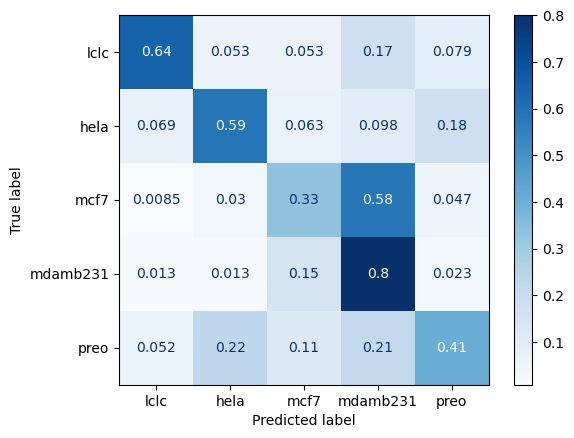

In [124]:
exp = experiments[0]['experiments'][0]
labels, label_ids = get_dictionary(DATA_PATH)
x_test, y_test, test_labels = get_test(DATA_PATH, labels)
y_pred, pred_labels = get_predictions(exp, labels)
cm = confusion_matrix(test_labels, pred_labels, labels=labels, normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(cmap=mpl.cm.Blues)
plt.show()

In [144]:
label_count = len(labels)
cmap = mpl.cm.get_cmap('Set1', label_count)
edge_cmap = mpl.cm.get_cmap('viridis')
norm = mpl.colors.Normalize(0, 20)
G = nx.circulant_graph(len(labels), [0])

# set 2D positions
import math

node_pos = {}
node_size = []
node_color = []
edge_widths = {}
edge_colors = {}


for i in range(len(labels)):
    theta = 2 * math.pi * i / 5 + math.pi / 2
    node_pos[i] = (2 * math.cos(theta), 2 * math.sin(theta))  # outer vertices
    node_color.append(mpl.colors.rgb2hex(cmap(i)))
    
for i in label_ids:
    node_size.append(cm[i,i] * 100)

for i in label_ids[:-1]:
    for j in label_ids[1:]:
        G.add_edge(i,j)
        wdth = (cm[i, j] * .5 + cm[j, i] * .5) * 50
        edge_widths[(i,j)] = wdth
        edge_colors[(i,j)] = mpl.colors.rgb2hex(edge_cmap(norm(wdth)))
        

# for v in G:
#     print('%d: (%6s, %6s)' % (v, '%.3f' % node_pos[v][0], '%.3f' % node_pos[v][1]))
print(edge_widths)
print(edge_colors)

{(0, 1): 3.0399274047186933, (0, 2): 1.528555431131019, (0, 3): 4.6085417030949465, (0, 4): 3.264006791171477, (1, 1): 29.597701149425287, (1, 2): 2.3251406211787726, (1, 3): 2.7747546492534467, (1, 4): 9.937893956247683, (2, 1): 2.3251406211787726, (2, 2): 16.595744680851062, (2, 3): 18.312009613345584, (2, 4): 3.912148249828415, (3, 1): 2.7747546492534467, (3, 2): 18.312009613345584, (3, 3): 40.033222591362126, (3, 4): 5.903975993998499}
{(0, 1): '#463480', (0, 2): '#481c6e', (0, 3): '#3e4c8a', (0, 4): '#453882', (1, 1): '#fde725', (1, 2): '#482979', (1, 3): '#46307e', (1, 4): '#21908d', (2, 1): '#482979', (2, 2): '#8ed645', (2, 3): '#c8e020', (2, 4): '#414287', (3, 1): '#46307e', (3, 2): '#c8e020', (3, 3): '#fde725', (3, 4): '#355e8d'}


In [147]:
vis = GraphVisualization(
    G,
    node_pos,
    node_text_position='top center',
    node_size=node_size,
    node_color=node_color,                   # color vertices based on their IDs
    node_text=labels,
    edge_color=edge_colors,
    edge_width=edge_widths,
    edge_opacity=1,
    node_opacity=1,
)
fig = vis.create_figure()
fig.show()